In [26]:
%pip install nltk
%pip install scikit-learn
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [27]:
import nltk
#I added this because of a lookup error for nltk
#nltk.download()
import sklearn
import matplotlib.pyplot as plt
import csv

In [28]:
#get the data from the kaggledata_archive for n-grams (using all-data.csv)
import re
regex = re.compile(r'[^\w\s]*') #regular expression to get rid of punctuation marks
with open('./kaggledata_archive/all-data.csv', encoding='latin-1') as original_csv:
    financial_csv = csv.reader(original_csv)
    finance = list(financial_csv)
        
csv_data: list[str] = [t[1] for t in finance]
csv_data = [re.sub(r'[^\w\s]*', '', _) for _ in csv_data]

#Get rid of the first column of csv file



In [ ]:
#Task 1: N-gram Generation
from nltk.tokenize import word_tokenize
from collections import Counter

#Task 1: N-gram Generation
def n_gram_generation(csv_data: list[str], number_of_words: int) -> tuple[tuple[str]]:
    """A function that extracts a certain words from the csv file 
        into a list of tuple of strings

    Args:
        csv_file (pandas dataframe): a dataframe of a csv file containing all the financial headlines
        number_of_words (integer): the number of words to put in each tuple element 

    Returns:
        n_grams: a list of a tuple of all the words from the csv_file for each n-gram model
    """
    #for text in csv_file: Only iterating through the first row for some reason
        #tokens = word_tokenize(text)

    tokens: list[str] = []
    for line in csv_data:
        tokens.extend(word_tokenize(line))
    ngrams = tuple(tuple(tokens[i : i + number_of_words]) for i in range(len(tokens) - number_of_words + 1))
    return ngrams
    
unigram_model: tuple[tuple[str]] = n_gram_generation(csv_data, 1)
bigram_model: tuple[tuple[str]] = n_gram_generation(csv_data, 2)
trigram_model: tuple[tuple[str]] = n_gram_generation(csv_data, 3)

#Create the word cloud with the top 10 words for each model
unigram_frequency: list[tuple[str]] = Counter(unigram_model).most_common(10)
#print(unigram_frequency)
#Rewrite this for word cloud visualization
bigram_frequency: list[tuple[str]] = Counter(bigram_model).most_common(10)
#print(bigram_frequency)
trigram_frequency: list[tuple[str]] = Counter(trigram_model).most_common(10)
#print(trigram_frequency)


<class 'list'>


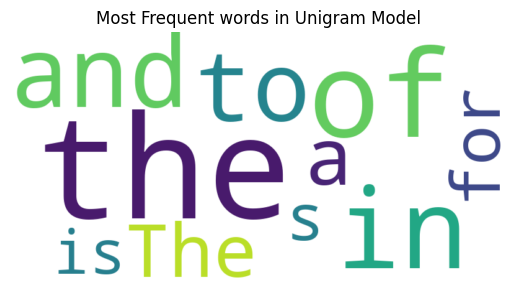

In [39]:
#Display the word cloud for unigram model
from wordcloud import WordCloud
#convert unigram_frequency into a dictionary
unigram_dict_frequency = {k[0]: v for k, v in unigram_frequency}
unigram_wordCloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unigram_dict_frequency)
plt.imshow(unigram_wordCloud, interpolation='bilinear')
plt.title("Most Frequent words in Unigram Model")
plt.axis("off")
plt.show()

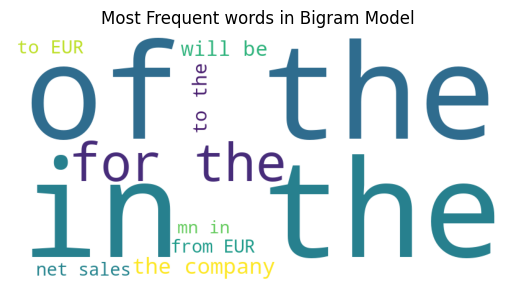

In [40]:
#Display the word cloud for bigram model
from wordcloud import WordCloud
#Convert from lis[tuple[str]] to dictionary to make it easier for wordcloud
bigram_dict_frequency = {' '.join(bigram): count for bigram, count in bigram_frequency}
bigram_wordCloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_dict_frequency)
plt.imshow(bigram_wordCloud)
plt.title("Most Frequent words in Bigram Model")
plt.axis("off")
plt.show()

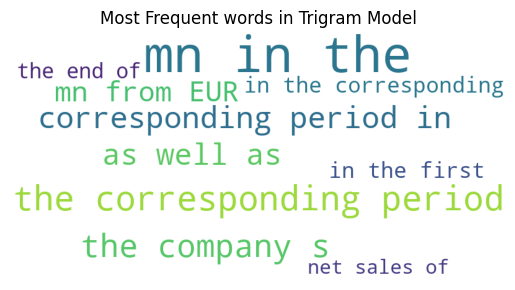

In [46]:
#Display the word cloud for trigram model
from wordcloud import WordCloud
trigram_dict_frequency = {' '.join(trigram): count for trigram, count in trigram_frequency}
trigram_wordCloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_dict_frequency)
plt.imshow(trigram_wordCloud)
plt.title("Most Frequent words in Trigram Model")
plt.axis("off")
plt.show()

In [ ]:
#Task 2: N-Gram Modeling

#This is the function to calculate perplexity
def calculate_perplexity():
    perplexity = 0
    return perplexity

#Printing the perplexity of each n-gram model
print(calculate_perplexity(unigram_model))
print(calculate_perplexity(bigram_model))
print(calculate_perplexity(trigram_model))

In [ ]:
#Task 3: Handling unseen n-grams

def laplace_smoothing():
    return

#Plotting the laplace smoothing of the n-gram models

In [ ]:
#Task 4: Interpolation
def interpolation():
    return

#Plotting the interpolated models vs the laplace smoothed models